In [ ]:
# default_exp data.load 

In [ ]:
# hide
import sys

sys.path.append("..")

In [ ]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.tabular.core import *
from fastseq.data.transforms import *

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
from nbdev.showdoc import *

# Data

> Using the fastai2 `DataSource` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 

In [ ]:
# export
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [ ]:
# export
class TSTensorSeq(TensorSeq): pass
class TSTensorSeqy(TensorSeq): 
    
    @classmethod
    def create(cls, t)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).view(-1, 1).float())
    
    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: 
            del kwargs['figsize']
        array = np.array(self.cpu())
        array = no_emp_dim(array)
        x_len = self._meta.get('x_len',0)
        m = self._meta.get('m','-*r')
        t = np.arange(x_len,x_len+array.shape[1])[None,:]
        ctx.plot(t, array, m, **kwargs)
        return ctx

TSTensorSeqy.loss_func = MSELossFlat()

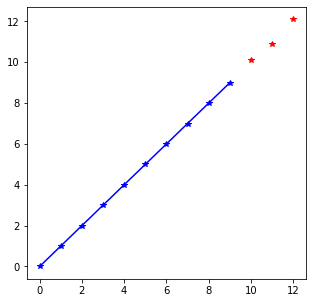

In [ ]:
ts = TSTensorSeq(np.arange(10))
ctx = ts.show()

y = TSTensorSeqy(np.array([10.1,10.9,12.1]), x_len=10)
y.show(ctx=ctx)

# Dataloader

In [ ]:
# export
# TODO maybe incl. start where the last one ended and therefor keep hidden state
@delegates()
class TSDataLoader(TfmdDL):
    def __init__(self, items, horizon, lookback=72, step=1, bs=64,  num_workers=0, device=None, **kwargs):
        self.items, self.horizon, self.lookback, self.step = items, horizon, lookback, step   
        self.make_ids()
        super().__init__(dataset=items, bs=bs, num_workers=num_workers, after_batch=[Cuda(device)], **kwargs)

    def make_ids(self):        
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        self._ids = {}
        for i, ts in enumerate(self.items):
            if isinstance(ts,tuple):
                ts = ts[0] # no idea why they become tuples 
            num_examples = (ts.shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts.shape[-1] < self.horizon:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts.shape[-1] < self.lookback + self.horizon:
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

            # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.items)))
        # Store the number of training examples
        self.n = int(self._ids.__len__() )
        
    def get_id(self,idx):        
        # Get time series
        ts_id, lookback_id = self._ids[idx]
        ts = self.items[ts_id]
        if isinstance(ts,tuple):
            ts = ts[0] # no idea why they become tuples 
        # Prepare input and target. Zero pad if necessary.
        if ts.shape[-1] < self.lookback + self.horizon:
            # If the time series is too short, we zero pad
            x = ts[:, :-self.horizon]
            x = np.pad(
                x, 
                pad_width=((0, 0), (self.lookback - x.shape[-1], 0)), 
                mode='constant', 
                constant_values=0
            )         
            y = ts[:,-self.horizon:]
        else:
            x = ts[:,lookback_id:lookback_id + self.lookback]
            y = ts[:,lookback_id + self.lookback:lookback_id + self.lookback + self.horizon]
        return x, y
        
    def shuffle_fn(self, idxs):
        self.items.shuffle()
        return idxs

    def create_item(self, idx):
        if idx>=self.n: raise IndexError
        x, y = self.get_id(idx)
        return TSTensorSeq(x),TSTensorSeqy(y, x_len=x.shape[1], m='-*g')


In [ ]:
# hide
horizon,lookback = 2,5
ints = L(np.arange(7)[None,:],np.arange(7,15)[None,:],np.arange(15,20)[None,:],np.arange(20,29)[None,:]).map(tensor)
dl = TSDataLoader(ints, horizon, lookback, device='cpu')
test_eq(list(dl),[(tensor([[[ 0,  1,  2,  3,  4]],[[ 7,  8,  9, 10, 11]],[[ 8,  9, 10, 11, 12]],[[ 0,  0, 15, 16, 17]]]), 
                   tensor([[[ 5,  6]],[[12, 13]],[[13, 14]],[[18, 19]]]))]
       )

In [ ]:
horizon,lookback = 2,5
ints = L(np.arange(7)[None,:],np.arange(7,15)[None,:],np.arange(15,20)[None,:],np.arange(20,29)[None,:]).map(tensor)
ints

(#4) [tensor([[0, 1, 2, 3, 4, 5, 6]]),tensor([[ 7,  8,  9, 10, 11, 12, 13, 14]]),tensor([[15, 16, 17, 18, 19]]),tensor([[20, 21, 22, 23, 24, 25, 26, 27, 28]])]

In [ ]:
dl = TSDataLoader(ints, horizon, lookback, device='cpu')
test_eq(list(dl),[(tensor([[[ 0,  1,  2,  3,  4]],[[ 7,  8,  9, 10, 11]],[[ 8,  9, 10, 11, 12]],[[ 0,  0, 15, 16, 17]]]), 
                   tensor([[[ 5,  6]],[[12, 13]],[[13, 14]],[[18, 19]]]))]
       )

In [ ]:
# hide
dl = TSDataLoader(ints, horizon, lookback, shuffle=True, device='cpu')
xy = tuple(dl)
test_eq(type(xy[0][0]), TSTensorSeq)

# Showing

In [ ]:
# export

from fastai2.vision.data import *

@typedispatch
def show_batch(x: TensorSeq, y, samples, ctxs=None, max_n=10,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    ctxs = show_batch[object](x, y, samples=samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs


# Intergration Example

In [ ]:
from fastseq.core import *
from fastai2.basics import *

In [ ]:
path = untar_data(URLs.m4_daily)
df_train = pd.read_csv(path/'train.csv',nrows=100)
df_test = pd.read_csv(path/'val.csv')
df_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,D1,2039.20,2035.00,2051.80,2061.8,2063.50,2069.5,2054.00,2057.00,2062.80,2066.40,2067.40,2071.40,2083.80,2080.60
1,D2,2986.00,3001.20,2975.90,2996.1,2981.90,2985.5,2975.80,2956.20,2964.70,2989.00,2991.40,3024.90,3070.80,3076.90
2,D3,1120.70,1117.90,1115.10,1112.3,1109.50,1106.7,1103.90,1101.10,1098.30,1095.50,1092.70,1089.90,1087.10,1084.30
3,D4,1190.00,1162.00,1134.00,1106.0,1078.00,1050.0,1022.00,994.00,966.00,938.00,910.00,1428.00,1400.00,1372.00
4,D5,5904.67,5917.05,5922.58,5928.8,5935.29,6002.8,6009.47,6014.82,6020.19,6072.49,6077.72,6080.23,6082.75,6108.07


In [ ]:
items = ts_lists(df_train.iloc[:,1:].values)

In [ ]:
horizon = 14
lookback = 128

In [ ]:
splits = RandomSplitter()(items)

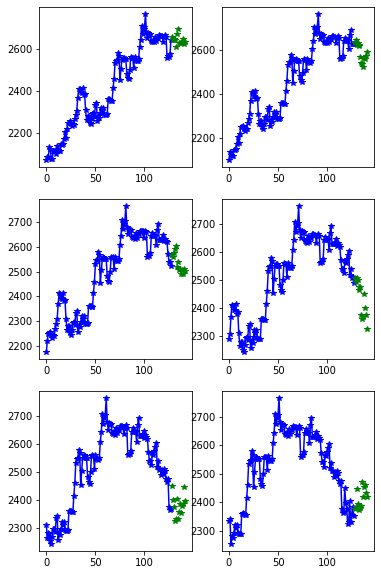

In [ ]:
dsrc = DataSource(items, splits=splits, dl_type=TSDataLoader)
dbunch = dsrc.databunch(bs=16, horizon=horizon, lookback=lookback, step=10)
dbunch.show_batch(max_n=6)

# TSDataBunch

In [ ]:
from fastseq.data.external import *
path = untar_data(URLs.m4_daily)
path.ls()

(#2) [Path('/home/tako/.fastai/data/m4_daily/train.csv'),Path('/home/tako/.fastai/data/m4_daily/val.csv')]

In [ ]:
#export
def TSBlock():
    return TransformBlock(dl_type=TSDataLoader,)

In [ ]:
#export
class TSDataBunch(DataBunch):
    @classmethod
    @delegates(DataBunch.__init__)
    def from_folder(cls, path, valid_pct=.2, seed=None, horizon=None, lookback=None, step=1, nrows=None, skiprows=None, device=None, **kwargs):
        """Create from M-compition style in `path` with `train`,`test` csv-files. 
        
        The `DataLoader` for the test set will be save as an attribute under `test_dl`
        """
        train, test = get_ts_files(path, nrows=nrows, skiprows=skiprows)
        horizon = ifnone(horizon, len(test[0]))
        lookback = ifnone(lookback, horizon * 3)
        step = step
        test = concat_ts_list(train, test, lookback)
        train, valid = sep_last(train, valid_pct)
        items = L(*train,*valid,*test)
        splits = IndexsSplitter(len(train),len(train)+len(valid), True)(items)
        dsrc = DataSource(items, noop, splits=splits, dl_type=TSDataLoader)
        db = dsrc.databunch(horizon=horizon, lookback=lookback, step=step, device=device, **kwargs)
        db.test_dl = dsrc.subset(2)
#         TODO add with test_dl, currently give buges I guess
        return db 


In [ ]:
# hide
dbunch = TSDataBunch.from_folder(path, horizon = 14, step=5, bs=64, nrows=100, device = 'cpu')
for o in dbunch.train_dl:
    test_eq(o[0].is_cuda, False)
    break
    

In [ ]:
show_doc(TSDataBunch.from_folder, name='TSDataBunch.from_folder')

<h4 id="TSDataBunch.from_folder" class="doc_header"><code>TSDataBunch.from_folder</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>TSDataBunch.from_folder</code>(**`path`**, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`horizon`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`nrows`**=*`None`*, **`skiprows`**=*`None`*, **`device`**=*`None`*)

Create from M-compition style in `path` with `train`,`test` csv-files. 

The `DataLoader` for the test set will be save as an attribute under `test_dl`

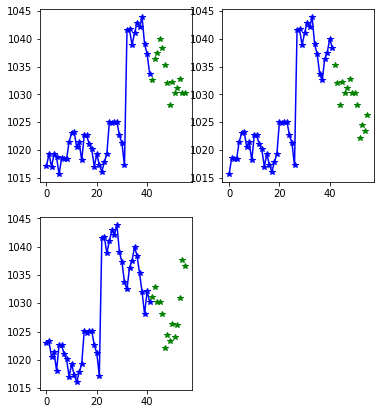

In [ ]:
dbunch = TSDataBunch.from_folder(path, horizon = 14, step=5, bs=64, nrows=100, device = 'cpu')
dbunch.train_dl.show_batch(max_n=3)

TODO also add a show batch on the `test_dl`

In [ ]:
# hide
test_eq(len(dbunch.train_ds),100)
test_eq(len(dbunch.valid_ds),100)
test_eq(len(dbunch.test_dl),100)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted 06_models.dnn.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 20_models.cnn.learner.ipynb.
Converted 21_models.cnn.transforms.ipynb.
Converted index.ipynb.
